# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

Нужно потребовать, чтобы на первом шаге оптимизации (мы выбираем ближайший центр кластера) мы выбирали в спорных ситуациях всегда один и тот же центр кластеризации. В противном случае алгоритм может не сойтись на некоторых примерах (там будет чередоваться разбиение). Как такой пример построить? Пример показан на рисунке. Изначально инициализируем центры кластеров как показано на рисунке (квадратики). Далее есть две пары точек, которые можно будет относить к кластерам 1 и 2, поскольку расстояние одинаковое. И можно добиться, чтобы алгоритм чередовал эти два варианта разбиения.

<img src="images/example.png">

**Лемма 1:** после каждого шага при изменении разбиения на кластеры функция Q (в обозначениях лекции) становится меньше.

**Доказательство леммы 1:** Есть 2 случая: либо изменились центры кластеров, либо не изменились.

* Центры кластеров изменились. Вспомним, что это действие оптимизировало Q при фиксированном и исходном разбиении в нашем алгоритме. Таким образом Q уменьшилось строго. 

* Центры кластеров не изменились, но изменилось разбиение на кластеры. Тогда каким-то объектам был найден кластер ближе и функционал качества опять уменьшился.


**Лемма 2:** пусть функционал качества убывает при каждом изменении разбиения. Тогда алгоритм сходится не более чем за $K^N$ шагов.

**Доказательство леммы 2:**
Пусть от противного алгоритм не сходится за такое число шагов в некоторых случаях. Заметим, что после инициализации каким-то образом центров кластеров и нахождения этих кластеров дальше каждое следующее разбиение на кластеры определяется только предыдущим разбиением. Всего возможных разбиений может быть не больше $K^N$. Таким образом какие-то разбиения будут повторяться, что означает наличие циклов длины больше 1, если алгоритм не сходится. Поскольку после каждого шага функция Q при изменении разбиения строго убывает, такого быть не может.

**Доказательство:** очевидно, лемма 1 и лемма 2 вместе.



Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:
￼
￼$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$
￼

***Ваше решение здесь***

Мы будем пользоваться тем, что $\Sigma$ &mdash; неотрицательно определенная симметричная обратимая матрица.

Оценка ММП по определению выглядит так:

$$\mu = argmax_\mu L(\mu) = agrmax_\mu \log L(\mu)$$.

Распишем $\log L(\mu)$

$$\log L(\mu) = n \log\left(\frac{1}{(2\pi)^{n/2} |\Sigma|^{1/2}}\right) - \sum_{i=1}^n \frac{1}{2} (x_i - \mu)^T \Sigma^{-1} (x_i - \mu)$$

Первое слагаемое очевидно от $\mu$ не зависит, поэтому оптимизировать нужно второе. Назовем его $Q(\mu)$. Посчитаем градиент и приравняем нулю:

$$0 = \nabla_\mu Q(\mu) = -\frac{1}{2} \sum_{i=1}^n \nabla_\mu (x_i - \mu)^T \Sigma^{-1} (x_i - \mu) = -\frac{1}{2} \sum_{i=1}^n \nabla_\mu \left[ x_i^T \Sigma^{-1} x_i - \mu^T \Sigma^{-1} x_i - x_i^T \Sigma^{-1} \mu + \mu^T \Sigma^{-1} \mu \right] = -\frac{1}{2} \sum_{i=1}^n \left[ 0 - \Sigma^{-1} x_i -  \Sigma^{-1} x_i + 2\Sigma^{-1} \mu \right] =\\= \sum_{i=1}^n \Sigma^{-1} (x_i - \mu),$$

откуда мы получаем точку возможного экстремума в $\mu = \frac{\sum_{i=1}^n x_i}{n}$.

Осталось проверить, что там максимум. Посчитаем гессиан. Нетрудно заметить (если расписать опять на 4 слагаемых и если использовать некоторые стандартные правила), что останется только $H(\mu) = -\sum_{i=1}^n \Sigma^{-1} = -n \Sigma^{-1}$. Что это за матрица? 

Ну, покажем, что $\Sigma^{-1}$ также неотрицательно определенная матрица. Квадратичная форма с матрицей  $\Sigma$ при преобразовании в базис столбцов $\Sigma^{-1}$ изменит свою матрицу на $(\Sigma^{-1})^T \Sigma \Sigma^{-1} = \Sigma^{-1}$. 

То есть наш гессиан неположительно определен. Этого недостаточно, чтобы сразу сказать про максимум, придется что-то подумать.
Ну, разложим нашу функцию в многочлен Тейлора с остаточным членом в форме Лагража в окрестности среднего ($\mu'$). Ну, из-за нулевых третьих производных он просто ноль. В итоге 

$$Q(\mu) = Q(\mu') + \left\langle \nabla_\mu Q \bigg\lvert_{\mu'},\: (\mu - \mu') \right\rangle + (\mu - \mu')^T H(\mu') (\mu - \mu') = Q(\mu') + 0 + (\mu - \mu')^T H(\mu') (\mu - \mu') \le Q(\mu'),$$

что завершает доказательство

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

1) single linkage:
$$d_{\min}(U \cup V, S) = \min_{\mathbf{x} \in (U \cup V), \mathbf{x}' \in S} \|\mathbf{x} -\mathbf{x}' \| = 
\min \lbrace \min_{\mathbf{x} \in U, \mathbf{x}' \in S} \|\mathbf{x} -\mathbf{x}' \|, \: \min_{\mathbf{x} \in V, \mathbf{x}' \in S} \|\mathbf{x} -\mathbf{x}' \| \rbrace = \min \lbrace d_{min}(U, S),\: d_{min}(V, S) \rbrace =\\= \frac{1}{2} \left[d_{min}(U, S) + d_{min}(V, S) - |d_{min}(U, S) - d_{min}(V, S)|\right]$$

2) complete linkage:

аналогично, но только с максимумами

в 1 и 2 мы пользовались тем, что $\min \{a, b\} = \frac{a + b - |a - b|}{2};\: \max\{a, b\} = \frac{a + b + |a - b|}{2}$.

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
import numpy

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """

    def __init__(self, metric, **kwargs):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.__metric = metric

        self.__x_len = None
        self.__linkage_matrix = None
        self.__labels = None

        if "n_clusters" in kwargs:
            self.__n_clusters = kwargs["n_clusters"]
        else:
            self.__n_clusters = 2

        if "linkage" in kwargs:
            self.__linkage = kwargs["linkage"]
        else:
            self.__linkage = "complete"

        def complete(a, b, size_a, size_b):
            return np.maximum(a, b)

        def single(a, b, size_a, size_b):
            return np.minimum(a, b)
        
        def average(a, b, size_a, size_b):
            return (a * size_a + b * size_b) / (size_a + size_b) 

        if self.__linkage == "complete":
            self.__dist_func = complete
        elif self.__linkage == "single":
            self.__dist_func = single
        elif self.__linkage == "average":
            self.__dist_func = average
        else:
            raise RuntimeError(
                "incorrect linkage '{}'".format(self.__linkage)
            )

    def fit_predict(self, x, y=None):
        """
        Use data matrix x to compute model parameters and predict clusters
        """

        preds = np.arange(x.shape[0], dtype=int)

        dist = np.full((x.shape[0] * 2 - 1, x.shape[0] * 2 - 1), np.inf)
        dist[:x.shape[0]:, :x.shape[0]:] = pairwise_distances(
            x, metric=self.__metric
        )
        dist[np.diag_indices(dist.shape[0])] = np.inf
        self.__linkage_matrix = np.full((x.shape[0] - 1, 4), np.nan)

        if y is not None:
            if y.shape[0] != x.shape[0]:
                raise RuntimeError("incorrect y shape")

            self.__labels = y
        else:
            self.__labels = np.arange(x.shape[0])

        def get_num(index):
            return self.__linkage_matrix[index - x.shape[0]][3] \
                if index >= x.shape[0] else 1

        for row, ind in enumerate(range(x.shape[0], 2 * x.shape[0] - 1)):
            i, j = np.unravel_index(np.argmin(dist, axis=None), dist.shape)
            
            size_i, size_j = get_num(i), get_num(j)
            num = size_i + size_j
            self.__linkage_matrix[row, ::] = (i, j, dist[i][j], num)
            d = self.__dist_func(dist[::, i], dist[::, j], size_i, size_j)
            dist[::, ind] = dist[ind, ::] = d
            dist[::, [i, j]] = dist[[i, j], ::] = np.inf

        for (i, j, *_), ind in zip(
                self.__linkage_matrix[:-self.__n_clusters + 1:, ::],
                range(x.shape[0], 2 * x.shape[0] - 1)
        ):
            preds[preds == i] = ind
            preds[preds == j] = ind

        return preds

    def plot_dendrogram(self, ax=None):
        """
        Try to visualize our data
        """
        if ax is None:
            dendrogram(self.__linkage_matrix, labels=self.__labels)
        else:
            dendrogram(self.__linkage_matrix, labels=self.__labels, ax=ax)


Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

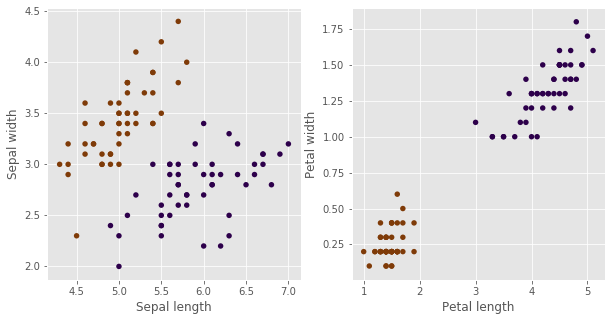

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [4]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.0015492439270019531


In [5]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='euclidean')
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.007881402969360352


# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

In [6]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [7]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
df_titles = pd.read_csv("docs_titles.tsv", sep='\t')

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3)).fit(df_titles.title.fillna(""))

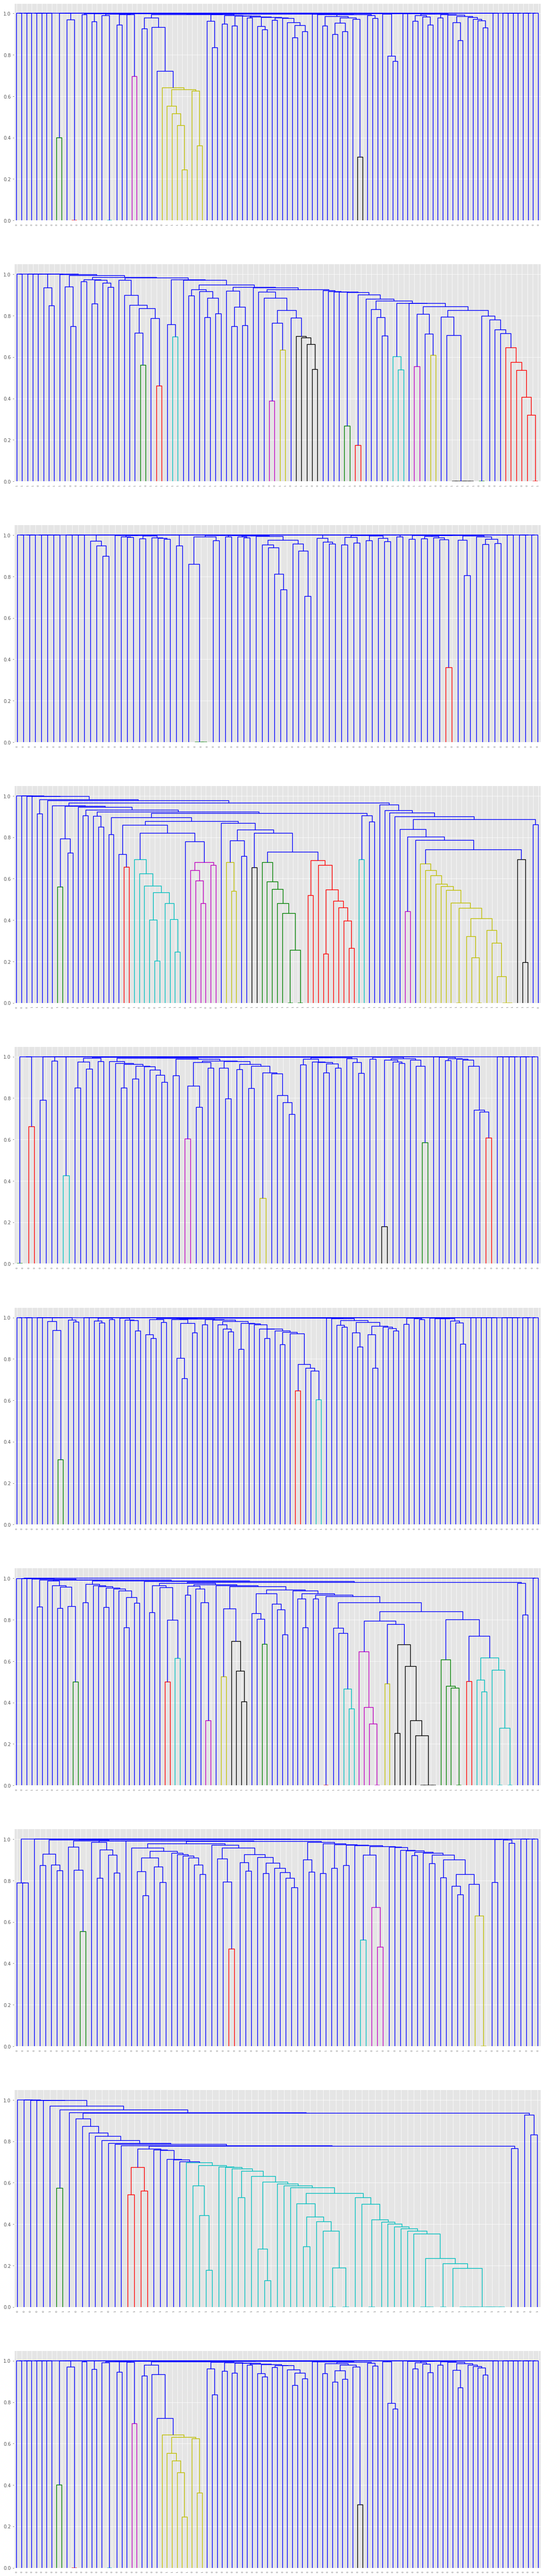

In [11]:
np.random.seed(239)
indices = np.random.choice(list(traingroups_titledata.keys()), 10)
pl.figure(figsize=(20, 100))
for i, ind in enumerate(indices):
    plt.subplot(10, 1, i + 1)
    titles = [t[1] for t in traingroups_titledata[ind]]
    target = [t[2] for t in traingroups_titledata[ind]]
    X = vectorizer.transform(titles)
    
    cluster = Clustering(metric='cosine', n_clusters=15, linkage="average")
    pred = cluster.fit_predict(X, np.array(target))
    #print(smt.adjusted_rand_score(target, pred))
    cluster.plot_dendrogram()

In [12]:
from sklearn.metrics import f1_score

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
full_target = []
predictions = []

In [15]:
for key in traingroups_titledata:
    titles = [t[1] for t in traingroups_titledata[key]]
    
    target = [t[2] for t in traingroups_titledata[key]]
    full_target.extend(target)
    
    X = vectorizer.transform(titles)
    cluster = Clustering(metric='cosine', n_clusters=2, linkage='average')
    pred = cluster.fit_predict(X)
    (label1, label2), (count1, count2) = np.unique(pred, return_counts=True)
    least_cluster = label1 if count1 < count2 else label2
    predictions.extend(np.asarray(pred != least_cluster, dtype=int))

In [16]:
f1_score(full_target, predictions)

0.46470012582133374

* Если в выборке есть аномалия, вероятно, до нее и расстояние будет больше. Что правда не очень так в случае наших документов, когда таргет=1 это почти что аномалия. Ну точнее как, обычно хорошие документы достаточно близки, если правильную метрику выбрать и может быть получше на токены разобрать, но можно наблюдать очень похожие аномальные документы друг на друга изредка даже на дендрограммах выше
* Ну, довольно хорошо работает косинусное расстояние
* Стоит попробовать результаты кластеризации использовать как дополнительные фичи

Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

**Отзыв по домашней работе**

Надо сказать, реализация интерфейса это немного не та задача, где стоит снижать баллы за стертый написанный код. Хотя может быть и не будет снижаться, а это про код с подготовкой датасета и прочее такое. Ну и вообще это та работа, где мне сложно оценить, сколько у меня будет реально баллов. Задание про боевое применение это всегда интересно и конкурс мне очень нравится, но тут оно все-таки слегка абстрактно сформулировано. Не много не ясно, в каком виде должен быть отчет, какого score стоит ожидать, чтобы себя проверить. Ну и со временем это в 3 раза кажется мне не очень правильным. В данном случае сложность у алгоритмов возможно даже выходит разной (я не уверен, но например scipy использует такие оптимизации) и тогда это больше про везение, что только в 3 раза, не говоря уже о некоторой зависимости от особенностей платформы. Может быть, было бы интересно узнать про такие оптимизации.

**Отзыв по всему курсу**

Мне все нравится, правда. И отлично, что обратная связь работает.